<a href="https://colab.research.google.com/github/Parth-nXp/CNN_mini_projects/blob/main/intel_images_spatial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install opendatasets --quiet
! pip install torchinfo --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/puneet6060/intel-image-classification")

Skipping, found downloaded files in "./intel-image-classification" (use force=True to force download)


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import datasets, transforms
from torch.optim import Adam
from torchinfo import summary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
normalize = transforms.Normalize(
    mean = [0.485, 0.456, 0.406],
    std = [0.229, 0.224, 0.225]
)

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    normalize
])

In [4]:
train_dataset = datasets.ImageFolder(
    root = "/content/intel-image-classification/seg_train/seg_train",
    transform = transform
    )
test_dataset = datasets.ImageFolder(
    root = "/content/intel-image-classification/seg_test/seg_test",
    transform = transform
)

In [5]:
print(train_dataset.classes)
print(test_dataset.classes)
print(train_dataset.class_to_idx)
print(test_dataset.class_to_idx)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [6]:
train_loader = DataLoader(train_dataset, batch_size = 128, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 128, shuffle = False)

In [7]:
class my_model(nn.Module):
  def __init__(self):
    super(my_model, self).__init__()
    self.conv1_layer = nn.Conv2d(3, 32, kernel_size = 3, padding = 1)
    self.relu = nn.ReLU()
    self.max_pool1 = nn.MaxPool2d(kernel_size= 2)

    self.conv2_layer = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
    self.max_pool2 = nn.MaxPool2d(kernel_size = 2)

    self.flatten = nn.Flatten()
    self.dropout = nn.Dropout(0.4)
    self.linear = nn.Linear(16384, 6)


  def forward(self, x):
    x = self.conv1_layer(x)
    x = self.relu(x)
    x = self.max_pool1(x)

    x = self.conv2_layer(x)
    x = self.relu(x)
    x = self.max_pool2(x)


    x = self.flatten(x)

    x = self.dropout(x)
    x = self.linear(x)

    return x


model = my_model().to(device)


In [8]:
summary(model, input_size= (1, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
my_model                                 [1, 6]                    --
├─Conv2d: 1-1                            [1, 32, 64, 64]           896
├─ReLU: 1-2                              [1, 32, 64, 64]           --
├─MaxPool2d: 1-3                         [1, 32, 32, 32]           --
├─Conv2d: 1-4                            [1, 64, 32, 32]           18,496
├─ReLU: 1-5                              [1, 64, 32, 32]           --
├─MaxPool2d: 1-6                         [1, 64, 16, 16]           --
├─Flatten: 1-7                           [1, 16384]                --
├─Dropout: 1-8                           [1, 16384]                --
├─Linear: 1-9                            [1, 6]                    98,310
Total params: 117,702
Trainable params: 117,702
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 22.71
Input size (MB): 0.05
Forward/backward pass size (MB): 1.57
Params size (MB): 0.47
Estimated Total Size

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = 0.001)

In [10]:
total_loss_plot_train = []
total_loss_plot_test = []

epochs = 20

for epoch in range(epochs):
  total_loss_train = 0
  total_loss_test = 0
  model.train()
  for data, label in train_loader:
    data = data.to(device)
    label = label.to(device)
    prediction = model(data)
    batch_loss = criterion(prediction, label)
    total_loss_train += batch_loss.item()

    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()

  with torch.no_grad():
    model.eval()
    for data, label in test_loader:
      data = data.to(device)
      label = label.to(device)
      prediction = model(data)
      batch_loss = criterion(prediction, label)
      total_loss_test +=  batch_loss.item()

  total_loss_plot_train.append(total_loss_train / len(train_loader))
  total_loss_plot_test.append(total_loss_test / len(test_loader))

  print(f'Epoch: {epoch + 1}, Train Loss: {total_loss_plot_train[-1]}, Test Loss: {total_loss_plot_test[-1]}')
  print("="*30)

Epoch: 1, Train Loss: 0.9746162463318218, Test Loss: 0.7954152127106985
Epoch: 2, Train Loss: 0.7358644983985207, Test Loss: 0.7115067125608524
Epoch: 3, Train Loss: 0.6124952814795754, Test Loss: 0.6256111823022366
Epoch: 4, Train Loss: 0.5194096123630351, Test Loss: 0.6061343736946583
Epoch: 5, Train Loss: 0.46930266564542594, Test Loss: 0.6345603441198667
Epoch: 6, Train Loss: 0.4238955557346344, Test Loss: 0.5854724285503229
Epoch: 7, Train Loss: 0.3735098494724794, Test Loss: 0.5989379199842612
Epoch: 8, Train Loss: 0.34229648804122753, Test Loss: 0.6121773893634478
Epoch: 9, Train Loss: 0.29776255867697976, Test Loss: 0.6313333051900069
Epoch: 10, Train Loss: 0.27910075919194655, Test Loss: 0.6723181574294964
Epoch: 11, Train Loss: 0.25623446161096747, Test Loss: 0.6381061983605226
Epoch: 12, Train Loss: 0.23286925757473165, Test Loss: 0.715226586908102
Epoch: 13, Train Loss: 0.2253137692809105, Test Loss: 0.6767607647925615
Epoch: 14, Train Loss: 0.19892428063533524, Test Loss: 

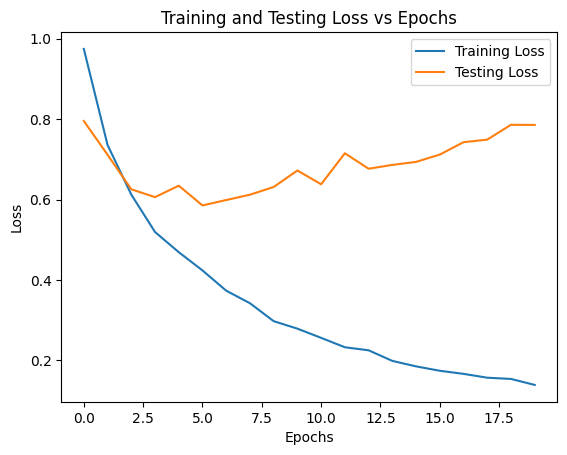

In [11]:
plt.plot(total_loss_plot_train, label = "Training Loss")
plt.plot(total_loss_plot_test, label = "Testing Loss")
plt.title("Training and Testing Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()